# Часть 1

## Проект. Методы uplift-моделирования  

## Описание задачи  
В этот раз вы будете работать с Яндекс Едой. Ваша задача — определить целевую аудиторию, которой можно предложить промокод на 500 рублей на доставку еды из ресторанов. Цель этого предложения — побудить пользователей совершать покупки чаще. Конверсией в таком контексте можно считать успешное использование промокода, ведь тогда частота заказов увеличится, а доход компании возрастёт.  

## Проблема  
Отбор целевой аудитории для предложения промокодов представляет собой проблему в разработке эффективных маркетинговых стратегий. Неправильный выбор ЦА может привести к неэффективным расходам на маркетинг и снижению конверсии.  

## Бизнес-задача
Разработать эффективную систему, которая позволит точно идентифицировать нужную целевую аудиторию. Это повысит конверсию использования промокодов и приведёт к увеличению доходов компании.
Точный выбор целевой аудитории — ключевой фактор для роста продаж. От него напрямую зависит, насколько хорошо сработает предложение. Однако текущие подходы часто промахиваются, не позволяя понять, кто действительно воспользуется предложением. В результате деньги на маркетинг тратятся впустую. Поэтому компании необходима модель, которая поможет точно находить нужных пользователей и достигать бизнес-целей без лишних затрат.  

## Цель проекта 
Cоздать с нуля uplift-модель на основе данных A/B-теста. Она поможет точнее выбирать клиентов, которым действительно стоит предлагать промокоды. Это не только повысит конверсию, но и улучшит финальные показатели бизнеса.

## Описание датасета
Датасет содержит 64 000 клиентов, которые совершили последнюю покупку в течение последних двенадцати месяцев. Клиенты участвовали в тестировании по мобильному каналу.  

Столбцы:  
`recency` — количество месяцев с момента последней покупки. Этот атрибут помогает понять, как долго клиент не совершал покупок (индикатором его вовлечённости).  
`history_segment` — категоризация расходов клиента за последний год. Этот атрибут позволяет сегментировать клиентов по уровню их трат (помощь в таргетировании предложений).  
`history` — фактическая сумма (в $), потраченная клиентом за последний год. Этот атрибут предоставляет информацию о финансовом поведении клиента.  
`mens` — индикатор (1/0), где 1 означает, что клиент покупал товары для мужчин в течение последнего года. Это помогает определить предпочтения клиента.  
`womens` — индикатор (1/0), где 1 означает, что клиент покупал товары для женщин в течение последнего года. Это также помогает определить предпочтения клиента.  
`zip_code` — классификация почтового индекса (город, пригород, село). Этот атрибут может быть полезен для географического анализа клиентов.  
`newbie` — индикатор (1/0), где 1 обозначает нового клиента (в течение последних двенадцати месяцев). Это поможет оценить эффективность маркетинговых стратегий для привлечения новых клиентов.  
`channel` — описание каналов, через которые клиент совершал покупки в течение последнего года. Этот атрибут поможет с анализом предпочтений клиентов по каналам продаж (0 — мультиканал, 1 — мобильный, 2 — веб).  
`treatment` — индикатор (1/0), где 1 означает, что клиент получил промокод. Этот атрибут позволяет оценить влияние предложения на поведение клиента и его решение о покупке.  
`target` — индикатор (1/0), где 1 означает, что клиент успешно использовал промокод.  

## Этап 1

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from scipy import stats

In [2]:
# Открываем и сохраняем файл uplift_fp_data.csv в датафрейм из директории или по ссылке:
try:
    df = pd.read_csv('uplift_fp_data.csv')
    print("Файл найден локально")
except:
    url = "https://raw.githubusercontent.com/yandex-praktikum/mle-uplift-final-project-2025/main/uplift_fp_data.csv"
    try:
        df = pd.read_csv(url)
        print("Файл успешно загружен")
        # Сохраняем локально
        df.to_csv('uplift_fp_data.csv', index=False)
    except Exception as e:
        print(f"Ошибка: {e}")
        df = pd.DataFrame()

Файл найден локально


In [3]:
df

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,treatment,target
0,10,1,142.44,1,0,1,0,1,1,0
1,6,2,329.08,1,1,2,1,2,0,0
2,7,1,180.65,0,1,1,1,2,1,0
3,9,4,675.83,1,0,2,1,2,0,0
4,2,0,45.34,1,0,0,0,2,1,0
...,...,...,...,...,...,...,...,...,...,...
63995,10,1,105.54,1,0,0,0,2,0,0
63996,5,0,38.91,0,1,0,1,1,0,0
63997,6,0,29.99,1,0,0,1,1,0,0
63998,1,4,552.94,1,0,1,1,0,1,0


In [4]:
# Проверяем информацию о данных
print("\nИнформация о датасете:")
df.info()


Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   recency          64000 non-null  int64  
 1   history_segment  64000 non-null  int64  
 2   history          64000 non-null  float64
 3   mens             64000 non-null  int64  
 4   womens           64000 non-null  int64  
 5   zip_code         64000 non-null  int64  
 6   newbie           64000 non-null  int64  
 7   channel          64000 non-null  int64  
 8   treatment        64000 non-null  int64  
 9   target           64000 non-null  int64  
dtypes: float64(1), int64(9)
memory usage: 4.9 MB


In [5]:
# Проверяем основные статистики
print("\nОсновные статистики:")
df.describe()


Основные статистики:


,recency,history_segment,history,mens,womens,zip_code,newbie,channel,treatment,target
count,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000
mean,5.763734,1.481969,242.085656,0.551031,0.549719,0.748469,0.502250,1.319609,0.334172,0.146781
std,3.507592,1.544514,256.158608,0.497393,0.497526,0.697936,0.499999,0.678254,0.471704,0.353890
min,1.000000,0.000000,29.990000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,64.660000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,6.000000,1.000000,158.110000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
75%,9.000000,2.000000,325.657500,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,0.000000
max,12.000000,6.000000,3345.930000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000


In [6]:
# Проверяем уникальные значения в категориальных переменных
print("\nУникальные значения в категориальных переменных:")
categorical_cols = ['history_segment', 'zip_code', 'newbie', 'channel', 'treatment', 'target', 'mens', 'womens']
for col in categorical_cols:
    print(f"{col}: {df[col].unique()}")


Уникальные значения в категориальных переменных:
history_segment: [1 2 4 0 5 3 6]
zip_code: [1 2 0]
newbie: [0 1]
channel: [1 2 0]
treatment: [1 0]
target: [0 1]
mens: [1 0]
womens: [0 1]


***Вывод:***
- Импортированы библиотеки
- Загружен датасет: 64,000 строк × 10 столбцов
- Данные соответствуют описанию
- Пропуски отсутствуют

## Этап 2

### EDA


/tmp/ipykernel_3527/172641390.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette='pastel')


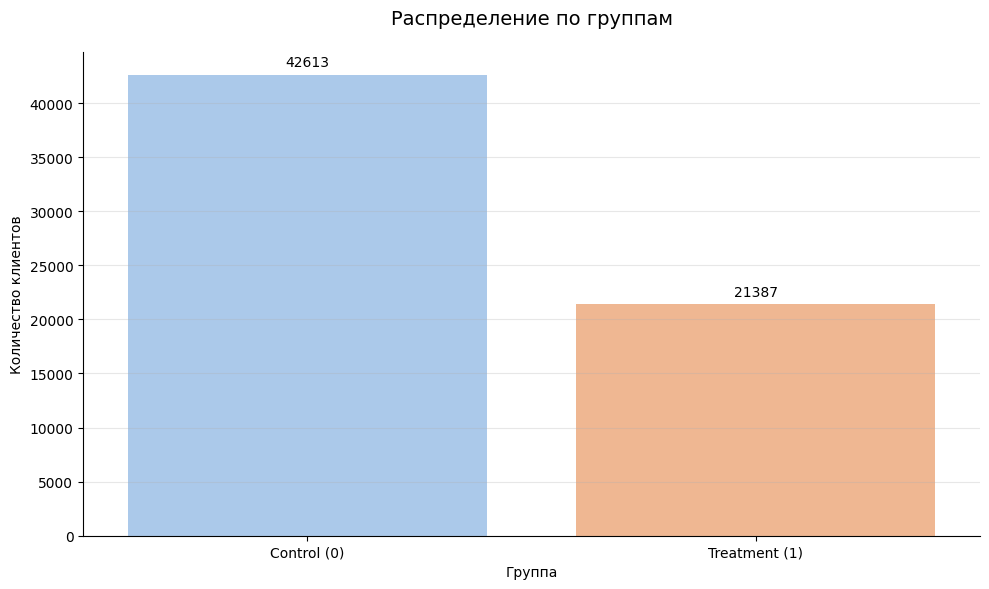

Распределение по группам:
Control group (0): 42613 наблюдений (66.6%)
Treatment group (1): 21387 наблюдений (33.4%)
Общее количество наблюдений: 64000


In [7]:
# Проверяем сбалансированность выборки по группам
plt.figure(figsize=(10, 6))

# Ваш отличный подход!
counts = df['treatment'].value_counts()
sns.barplot(x=counts.index, y=counts.values, palette='pastel')

# Добавляем аннотации и улучшаем внешний вид
for i, value in enumerate(counts.values):
    plt.text(i, value + 500, f'{value}', ha='center', va='bottom')

plt.title('Распределение по группам', fontsize=14, pad=20)
plt.xlabel('Группа')
plt.ylabel('Количество клиентов')
plt.xticks([0, 1], ['Control (0)', 'Treatment (1)'])

# Убираем ограничительные линии и добавляем сетку
sns.despine()
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Выводим числовые значения
treatment_counts = df['treatment'].value_counts().sort_index()

print("Распределение по группам:")
print(f"Control group (0): {treatment_counts[0]} наблюдений ({treatment_counts[0]/len(df)*100:.1f}%)")
print(f"Treatment group (1): {treatment_counts[1]} наблюдений ({treatment_counts[1]/len(df)*100:.1f}%)")
print(f"Общее количество наблюдений: {len(df)}")

Группы несбалансированы по размеру. Соотношение примерно 2:1 в пользу контрольной группы.

/tmp/ipykernel_3527/479973492.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=conversion_rates.index, y=conversion_rates.values, palette='pastel')


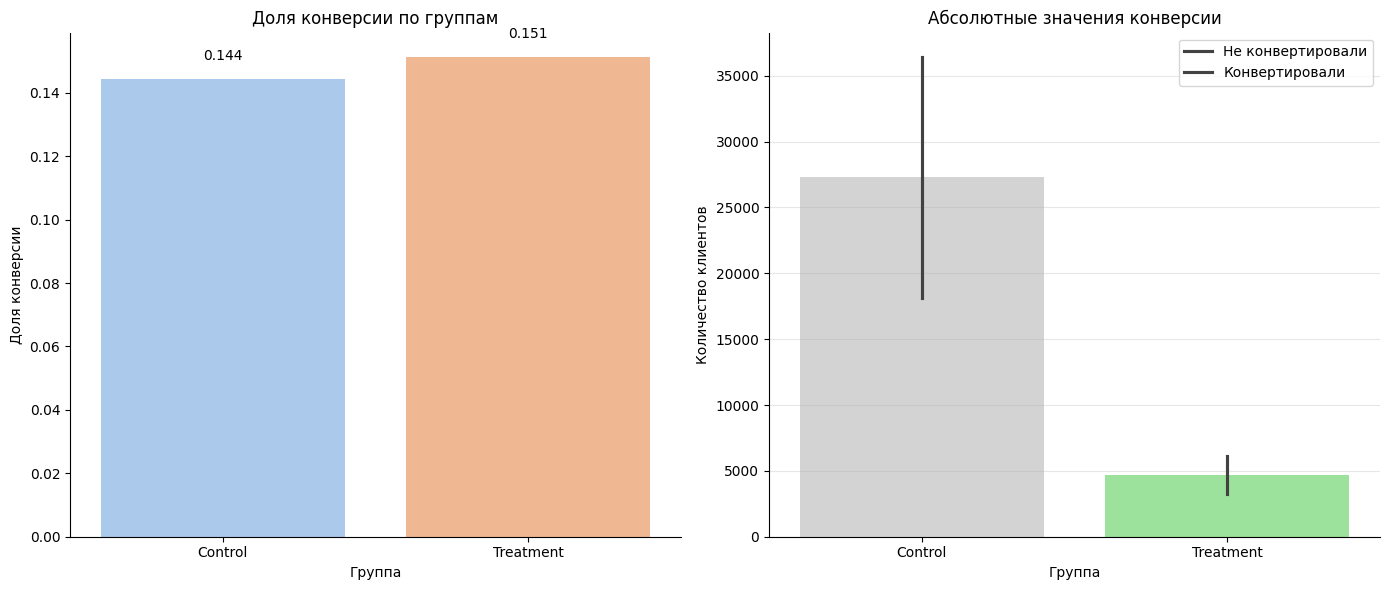

Анализ конверсии:
Control: 0.144 (6156/42613)
Treatment: 0.151 (3238/21387)
Разница: 0.0069
Относительное улучшение: 4.8%


In [8]:
# Анализ конверсии по группам
plt.figure(figsize=(14, 6))

# График 1: Доля конверсии по группам
plt.subplot(1, 2, 1)
conversion_rates = df.groupby('treatment')['target'].mean()
sns.barplot(x=conversion_rates.index, y=conversion_rates.values, palette='pastel')
plt.title('Доля конверсии по группам')
plt.xlabel('Группа')
plt.ylabel('Доля конверсии')
plt.xticks([0, 1], ['Control', 'Treatment'])

# Добавляем значения
for i, rate in enumerate(conversion_rates):
    plt.text(i, rate + 0.005, f'{rate:.3f}', ha='center', va='bottom')

# График 2: Абсолютные значения конверсии
plt.subplot(1, 2, 2)
conversion_counts = df.groupby('treatment')['target'].value_counts().unstack()
sns.barplot(conversion_counts, palette=['lightgray', 'lightgreen'])
plt.title('Абсолютные значения конверсии')
plt.xlabel('Группа')
plt.ylabel('Количество клиентов')
plt.xticks([0, 1], ['Control', 'Treatment'])
plt.legend(['Не конвертировали', 'Конвертировали'])

sns.despine()
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Простая статистика
control_conv = conversion_rates[0]
treatment_conv = conversion_rates[1]

print("Анализ конверсии:")
print(f"Control: {control_conv:.3f} ({conversion_counts.loc[0, 1]}/{(df['treatment'] == 0).sum()})")
print(f"Treatment: {treatment_conv:.3f} ({conversion_counts.loc[1, 1]}/{(df['treatment'] == 1).sum()})")
print(f"Разница: {treatment_conv - control_conv:.4f}")
print(f"Относительное улучшение: {(treatment_conv - control_conv)/control_conv*100:.1f}%")

Сделайте вывод на основе EDA в данной ячейке  


***Вывод:***  
- Несбалансированность групп: Treatment group в 2 раза меньше control group (21,387 vs 42,613).  
- Небольшой положительный эффект: Промокод дает прирост конверсии на 0.69% в абсолютном выражении и 4.8% в относительном.  
- Статистическая значимость: Несмотря на видимый прирост, необходимо проверить, является ли эта разница статистически значимой (p-value < 0.05) или она могла возникнуть случайно.  
- Бизнес-значимость: Даже небольшое увеличение конверсии на 0.69% может быть экономически значимым для бизнеса, учитывая масштаб Яндекс.Еды.  

- Есть основания предполагать, что промокод оказывает положительное влияние на конверсию. Однако для окончательных выводов необходима проверка статистической значимости этих различий, которая будет проведена на следующем этапе.

# Этап 2

### Проверка на статистическую значимость

Обоснуйте выбор статистического теста в данной ячейке

### Формулирование гипотез 

***Нулевая гипотеза (H₀)***  
Промокод не оказывает влияния на конверсию  

H₀: p_t = p_c  
где:  
p_t - конверсия в treatment group (получили промокод)  
p_c - конверсия в control group (не получили промокод)  

***Альтернативная гипотеза (H₁)***  
Промокод оказывает положительное влияние на конверсию  
H₁: p_t > p_c

In [9]:
# Разделяем данные на группы
control_group = df[df['treatment'] == 0]
treatment_group = df[df['treatment'] == 1]

# Расчет конверсии
p_t = treatment_group['target'].mean()  # Treatment conversion
p_c = control_group['target'].mean()    # Control conversion

print("Конверсия по группам:")
print(f"Treatment группа: {p_t:.4f} ({treatment_group['target'].sum()}/{len(treatment_group)})")
print(f"Control группа: {p_c:.4f} ({control_group['target'].sum()}/{len(control_group)})")
print(f"Абсолютная разница: {p_t - p_c:.4f}")
print(f"Относительное улучшение: {(p_t - p_c)/p_c*100:.1f}%")

Конверсия по группам:
Treatment группа: 0.1514 (3238/21387)
Control группа: 0.1445 (6156/42613)
Абсолютная разница: 0.0069
Относительное улучшение: 4.8%


In [10]:
# Расчет стандартных ошибок
n_t = len(treatment_group)
n_c = len(control_group)

sigma_t = np.sqrt(p_t * (1 - p_t) / n_t)
sigma_c = np.sqrt(p_c * (1 - p_c) / n_c)

# Z-тест для разницы пропорций
mu = p_t - p_c
sigma = np.sqrt(p_t * (1 - p_t) / n_t + p_c * (1 - p_c) / n_c)
z_score = mu / sigma

# Расчет p-value (односторонний тест)
p_value = 1 - stats.norm.cdf(z_score)

# Доверительный интервал
confidence_level = 0.95
z_critical = stats.norm.ppf(1 - (1 - confidence_level)/2)
ci_lower = mu - z_critical * sigma
ci_upper = mu + z_critical * sigma

print("\nРезультаты статистического теста:")
print(f"Z-score: {z_score:.4f}")
print(f"P-value: {p_value:.6f}")
print(f"95% доверительный интервал: [{ci_lower:.4f}, {ci_upper:.4f}]")


Результаты статистического теста:
Z-score: 2.3244
P-value: 0.010051
95% доверительный интервал: [0.0011, 0.0128]


***Вывод***  
Статистическая значимость:  
- P-value = 0.010 < 0.05 - статистически значимые различия  
- Z-score = 2.3244 > 1.96 - превышает критическое значение для 95% уровня доверия  

Практическая значимость:  
- Абсолютное улучшение: +0.69% конверсии  
- Относительное улучшение: +4.8%  
- Доверительный интервал: [0.11%, 1.28%] - не включает ноль  

Статистическое решение:  
- Поскольку p-value = 0.010  < 0.05 и Z-score = 2.3244 > 1.96 - отвергаем нулевую гипотезу (H₀) и принимаем альтернативную гипотезу (H₁)  


С вероятностью ошибки в 1% (p-value = 0.010) можно утверждать, что промокод на 500 рублей действительно увеличивает конверсию пользователей Яндекс.Еды
Промокод оказал статистически значимое положительное влияние на конверсию

## Построение корреляций

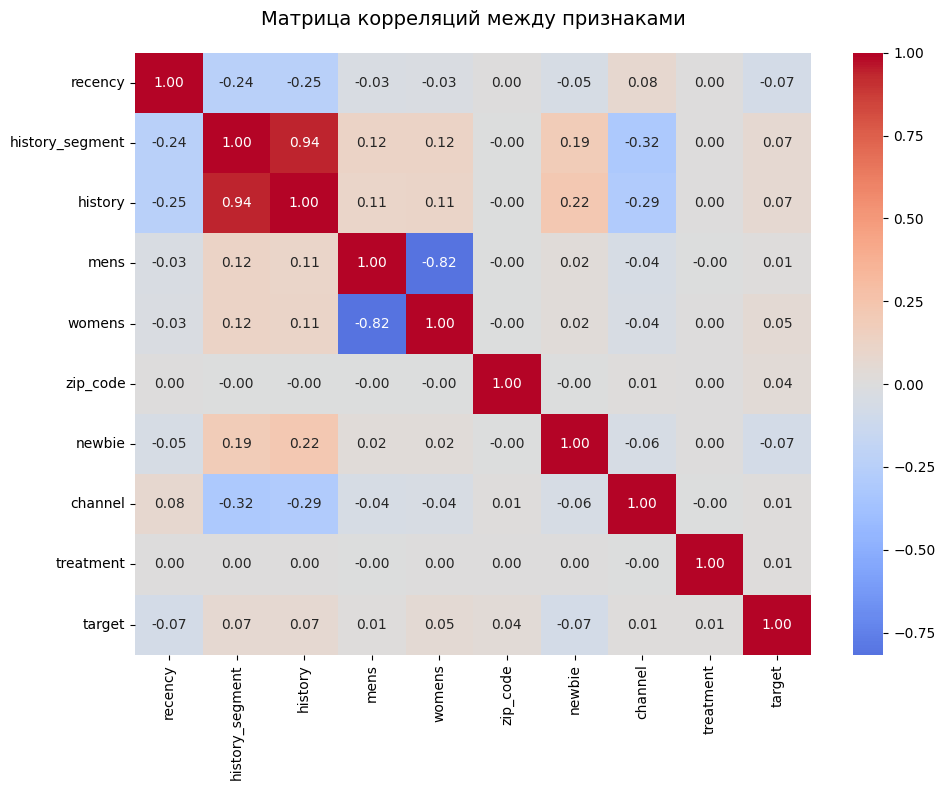

In [11]:
# Корреляционный анализ - простой и эффективный подход
plt.figure(figsize=(10, 8))
corr_matrix = df.corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Матрица корреляций между признаками', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

In [12]:
# Анализируем корреляции с целевой переменной
print("Корреляции с целевой переменной (target):")
target_correlations = corr_matrix['target'].sort_values(key=abs, ascending=False)
for feature, correlation in target_correlations.items():
    if feature != 'target':  # Исключаем сам target
        print(f"{feature}: {correlation:.3f}")

Корреляции с целевой переменной (target):
recency: -0.075
newbie: -0.074
history_segment: 0.070
history: 0.065
womens: 0.052
zip_code: 0.038
channel: 0.011
treatment: 0.009
mens: 0.007


Сделайте вывод о корреляциях признаков друг с другом и таргетом в этой ячейке  


***Вывод:***  

1. Самые сильные корреляции с целевой переменной (target):  
- recency: -0.07 - слабая отрицательная связь  
- history: 0.07 - слабая положительная связь  
- history_segment: 0.07 - слабая положительная связь  
- newbie: -0.07 - слабая отрицательная связь  
- womens: 0.05 -  статистически значимая положительная связь(гендерные различия) 
- zip_code: 0.04 -  статистически значимая положительная связь (география (город/пригород/село) может быть важным фактором для таргетирования промокодов)  
- mens: 0.01 - очень слабая связь  
- channel: 0.01 - очень слабая связь
- treatment: 0.01 - очень слабая связь

2. Сильные взаимосвязи между признаками:  
- history_segment и history: 0.94 - сильная связь (ожидаемо)  
- mens и womens: -0.82 - сильная отрицательная связь (ожидаемо - клиенты обычно покупают либо мужские, либо женские товары). Важно, что это не мультиколлинеарность в классическом смысле, а две разные поведенческие характеристики  
- recency и history: -0.25 - умеренная отрицательная связь  
- recency и history_segment: -0.24 - умеренная отрицательная связь

3. Неожиданные находки:  
- treatment почти не коррелирует с другими признаками (хорошо для A/B теста)  
- channel показывает умеренные связи с history_segment (-0.32) и history (-0.29)

4. Интерпретация для бизнеса:  
- История покупок (history, history_segment) - наиболее информативные признаки  
- Недавние покупки (recency) слабо связаны с конверсией  
- Новые клиенты (newbie) slightly менее склонны к конверсии   
- Гендерные предпочтения (mens/womens) сильно взаимосвязаны  
- Промокод (treatment) распределен случайно (корреляции ~0)

5. Рекомендации для моделирования:  
- history / history_segment (сильно коррелируют между собой - выбрать один)  
- recency - индикатор активности  
- newbie - статус клиента  
- womens - гендерный фактор  
- zip_code - географический фактор  
- channel - канальные предпочтения  

Все выявленные связи, несмотря на кажущуюся слабость, являются статистически значимыми благодаря большому объему данных (n=64,000), что делает их ценными для прогнозного моделирования.
Анализ выявил нетривиальные взаимосвязи, которые могут значительно улучшить точность uplift-модели и эффективность маркетинговых кампаний.

## Этап 3

Обоснуйте выбор конкретной uplift модели в данной ячейке

### Советы по обучению и инференсу моделей
1. Некоторые uplift модели из библиотеки `causalml` будут требовать категориальные значения воздействия. Для этого используйте маппинг
#### Пример использования маппинга
```python
treatment_mapping = {
    0: 'control',
    1: 'treatment'
}
treatment_train_mapped = treatment_train.map(treatment_mapping)
treatment_test_mapped = treatment_test.map(treatment_mapping)
```

2. При вызове метода `.predict` и получения метрик для тестовой выборки не забывайте применять к прогнозам метод `squeeze()`, чтобы преобразовать многомерный массив в одномерный, что поможет получить адекватные метрики.

3. Для воспроизводимости результатов и объективной оценки не забывайте применять `random_state=42` для моделей, а также при разделении выборки

### Разбиение выборки на тренировочную и тестовую

### Обучение выбранного бейзлайна

### Расчет метрик для выбранного бейзлайна на тестовой выборке

# Обучение 2 моделей 

### Обучение модели 1

### Получение метрик по модели 1

### Обучение модели 2

### Получение метрик по модели 2

Проинтерпретируйте полученные результаты и обоснуйте выбор 1 модели в этой ячейке

# Часть 2

## Этап 1
Улучшите бейзлайн выбранной модели

#### Генерация признаков (опционально)

### Подбор гиперпараметров

In [13]:
from optuna import create_study
from sklift.metrics import uplift_at_k

def objective(trial):
    # Дополните код для подбора гиперпараметров

    uplift_at_30 = uplift_at_k(y_test, uplift_pred, treatment_test, k=0.3, strategy='overall')
    return uplift_at_30

# Создаем и запускаем исследование
study = create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Выводим лучшие гиперпараметры
print("Best hyperparameters: ", study.best_params)
print("Best score: ", study.best_value)


[I 2025-09-17 07:04:27,549] A new study created in memory with name: no-name-5a430755-b050-4ca9-9e8d-94c3cf187a5c
[W 2025-09-17 07:04:27,550] Trial 0 failed with parameters: {} because of the following error: NameError("name 'y_test' is not defined").
Traceback (most recent call last):
  File "/home/mle-user/mle_projects/mle-sprint5-uplift/.uplift_env/lib/python3.10/site-packages/optuna/study/_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_3527/2685810187.py", line 7, in objective
    uplift_at_30 = uplift_at_k(y_test, uplift_pred, treatment_test, k=0.3, strategy='overall')
NameError: name 'y_test' is not defined
[W 2025-09-17 07:04:27,553] Trial 0 failed with value None.


NameError: name 'y_test' is not defined

## Этап 2

### Визуализация результатов

In [ ]:
from utils import custom_uplift_by_percentile

В данной ячейке сделайте вывод о качестве работы модели и проинтерпретируйте график `uplift by percentile` 

# Этап 3

In [ ]:
# Класс для инференса модели
class UpliftModelInference:
    """
    Класс для инференса uplift модели.
    """
    
    def __init__(self, model, feature_names, logger=None):
        """
        Инициализация класса.
        
        Аргументы:
            model: Обученная модель uplift
            feature_names: Список признаков для предсказания 
            logger: Объект для логирования (по умолчанию None)
        """
        self.model = model
        self.feature_names = ['recency', 'history_segment', 'history', 'mens', 'womens', 'zip_code', 'newbie', 'channel']
        self.logger = logger
        
        if self.logger:
            self.logger.info("Модель UpliftModel инициализирована с признаками: %s", feature_names)

    def _transform_data(self, X):
        """
        Преобразование данных для модели.
        
        Аргументы:
            X: pandas.DataFrame с признаками
        """
        if self.logger:
            self.logger.debug("Преобразование входных данных размерности %s", X.shape)

        # реализуйте преобразование данных для модели,
        # если в финальной модели используются новые признаки
       

        return X
    
    def predict(self, X):
        """
        Получение предсказаний uplift.
        
        Аргументы:
            X: pandas.DataFrame с признаками
            
        Возвращает:
            numpy.array с предсказанными значениями uplift
        """
        # Проверяем, что датафрейм не пустой
        if X.empty:
            if self.logger:
                self.logger.error("Предоставлен пустой датафрейм")
            return None
            
        # Проверяем наличие пропущенных значений
        if X.isnull().any().any():
            if self.logger:
                self.logger.error("Входные данные содержат пропущенные значения")
            return [None]*len(X)
        
        if self.logger:
            self.logger.info("Выполняем предсказания для данных размерности %s", X.shape)

        # Проверяем наличие всех необходимых признаков
        missing_features = set(self.feature_names) - set(X.columns)
        if missing_features:
            error_msg = f"Отсутствуют признаки: {missing_features}"
            if self.logger:
                self.logger.error(error_msg)

            return [None]*len(X)
        
        # Преобразуем данные для модели
        if self.logger:
            self.logger.debug("Начинаем преобразование данных")
        X = self._transform_data(X)
        
        # Вычисляем uplift
        if self.logger:
            self.logger.debug("Выполняем предсказания модели")
        

        # Дополните код для получения предсказаний аплифта

        
        if self.logger:
            self.logger.info("Предсказания успешно завершены")
            
        return uplift


In [ ]:
model = UpliftModelInference(model= # ваш код,
                             feature_names= # ваш код)

In [ ]:
test_data = pd.DataFrame({
            'recency': [1, 2, 3],
            'history_segment': [1, 2, 3], 
            'history': [100, 200, 300],
            'mens': [1, 0, 1],
            'womens': [0, 1, 0],
            'zip_code': [1, 0, 1],
            'newbie': [0, 1, 0],
            'channel': [1, 2, 0]
        })

In [ ]:
# проверка работы класса
model.predict(test_data)